In [6]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import glob
import cv2
import os
import random
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16
import seaborn as sns
from sklearn import preprocessing
import joblib
import xgboost as xgb
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report

In [7]:
SIZE = 256
SEED_TRAINING = 121
SEED_TESTING = 197
SEED_VALIDATION = 164
CHANNELS = 3
n_classes = 3
EPOCHS = 50
BATCH_SIZE = 16
input_shape = (SIZE, SIZE, CHANNELS)

In [12]:
def training(path):
    train_images = []      
    train_labels = []     

    path = path + r'\*'
    for directory_path in glob.glob(path):   
        label = directory_path.split('\\')[-1]       
        
        for img_path in glob.glob(os.path.join(directory_path, '*.JPG')):    
            img = cv2.imread(img_path)     
            if img is not None and not img.size == 0:
                img = cv2.resize(img, (SIZE, SIZE))        
                
                train_images.append(img)
                train_labels.append(label)
    
    train_data = list(zip(train_images, train_labels))
    random.seed(SEED_TRAINING)   
    random.shuffle(train_data)
    train_images, train_labels = zip(*train_data)   
    
    # converting tuples to numpy array.
    train_images = np.array(train_images)
    train_labels = np.array(train_labels)
    
    # let's normalize our pixel values 
    train_images = train_images / 255.0
    return train_images, train_labels

def testing(path) : 
    test_images = []
    test_labels = []
    
    path = path + r'\*'
    for directory_path in glob.glob(path) : 
        labels = directory_path.split('\\')[-1]
        for img_path in glob.glob(os.path.join(directory_path, '*.JPG')) : 
            img = cv2.imread(img_path)
            # img = cv2.merge((img, img, img)) 
            img = cv2.resize(img, (SIZE, SIZE))
            test_images.append(img)
            test_labels.append(labels)
            
    # Shuffling testing data
    test_data = list(zip(test_images, test_labels))
    random.seed(SEED_TESTING)
    random.shuffle(test_data)
    test_images, test_labels = zip(*test_data)
    test_images = np.array(test_images)
    test_labels = np.array(test_labels)
    
    # let's normalize our pixel values
    test_images = test_images / 255.0
    return test_images, test_labels

def preprocess_data(path, seed):
    images = []
    labels = []

    for class_name in os.listdir(path):
        class_path = os.path.join(path, class_name)
        if os.path.isdir(class_path):
            for img_path in glob.glob(os.path.join(class_path, '*.JPG')):
                img = cv2.imread(img_path)
                if img is not None and not img.size == 0:
                    img = cv2.resize(img, (SIZE, SIZE))
                    img = img / 255.0  # Normalize pixel values
                    images.append(img)
                    labels.append(class_name)

    data = list(zip(images, labels))
    random.seed(seed)
    random.shuffle(data)
    images, labels = zip(*data)
    return np.array(images), np.array(labels)

# Preprocess training data
X_train, y_train_labels = preprocess_data(r'C:\Users\Keerthi\Downloads\MyPCOS\data\train', seed=SEED_TRAINING)

# Preprocess testing data
X_test, y_test_labels = preprocess_data(r'C:\Users\Keerthi\Downloads\MyPCOS\data\test', seed=SEED_TESTING)


In [13]:
# encoding labels from text to integer
le = preprocessing.LabelEncoder()
le.fit(y_train_labels)
train_label_encoded = le.transform(y_train_labels)
le.fit(y_test_labels)
test_label_encoded = le.transform(y_test_labels)

In [14]:
# extracting original labels, later we will need it.
labels = dict(zip(le.classes_,range(len(le.classes_))))
print(labels)

{'infected': 0, 'notinfected': 1}


In [15]:
# Alias the encoded labels for better understanding
y_train, y_test = train_label_encoded, test_label_encoded

In [16]:
# Load the VGG16 model with pre-trained ImageNet weights
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(SIZE, SIZE, 3)) 

In [17]:
# Freeze all layers in the VGG16 model
for layer in vgg_model.layers: 
    layer.trainable = False

# Display the summary of the VGG16 model
vgg_model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 256, 256, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 256, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 128, 128, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 128, 128, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 64, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 32, 32, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [18]:
# Extract features from the training images using the VGG16 model
feature_extractor = vgg_model.predict(X_train)

# Reshape the extracted features for training data
features = feature_extractor.reshape(feature_extractor.shape[0], -1)
X_train_features = features

61/61 ━━━━━━━━━━━━━━━━━━━━ 356s 5s/step


In [19]:
# Extract features from the testing images using the VGG16 model
feature_extractor_test = vgg_model.predict(X_test)
features_test = feature_extractor_test.reshape(feature_extractor_test.shape[0], -1)
X_test_features = features_test

60/60 ━━━━━━━━━━━━━━━━━━━━ 434s 5s/step


In [20]:
# Initialize the XGBoost classifier model
model = xgb.XGBClassifier()

# Train the XGBoost classifier model using the extracted features and training labels
model.fit(X_train_features, y_train)

# Make predictions on the testing data using the trained model
prediction = model.predict(X_test_features)

# Inverse transform the predicted labels to get the original class labels
prediction = le.inverse_transform(prediction)

# Print the accuracy of the model on the testing data
print('Accuracy : ', metrics.accuracy_score(y_test_labels, prediction))

Accuracy :  1.0


<Axes: >

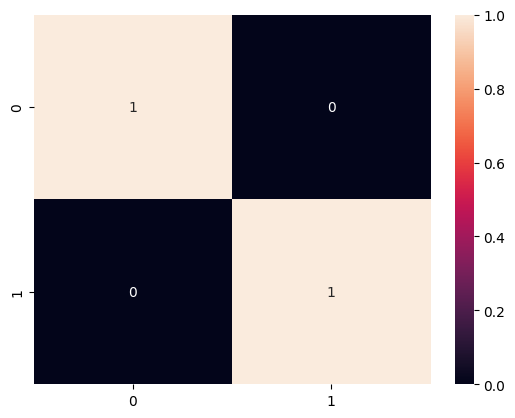

In [21]:
# Compute and plot the confusion matrix
cm = confusion_matrix(y_test_labels, prediction)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm, annot=True)

In [22]:
# Print the classification report
print(classification_report(y_test_labels, prediction))

              precision    recall  f1-score   support

    infected       1.00      1.00      1.00       781
 notinfected       1.00      1.00      1.00      1139

    accuracy                           1.00      1920
   macro avg       1.00      1.00      1.00      1920
weighted avg       1.00      1.00      1.00      1920



In [23]:
# Save the trained model
joblib.dump(model, 'ultrasound.pkl')

['ultrasound.pkl']